In [1]:
from astropy.time import Time
from astropy.table import Table
from glob import glob
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib import pyplot as plt
import numpy as np


data_table = Table.read('light_curve.csv')

In [2]:
print(data_table)

        mag                mag_error              time       
-------------------- --------------------- ------------------
-0.36515167887793787 0.0012437720304076432  6.403732270056583
-0.37002695032792055 0.0013074297918882684  6.434506986344434
 -0.3995663551090196 0.0013475154992632695   6.46627504756508
 -0.4368585623643053 0.0013333009751344692   6.49764699121771
 -0.4386347401109063  0.001319529628843062   6.52840171387253
 -0.4335073914868026 0.0013261428523563875  6.559132274294473
-0.44159137624707157 0.0013149233827168334  6.589983098263122
-0.46652365964371434 0.0013110569197523582  6.620758384520389
-0.43849792847709956 0.0012988614662515006  6.651541158611156
 -0.4588290124644949  0.001297266716848907  6.682366713935711
                 ...                   ...                ...
 -0.3654630227966873 0.0031506981735029598  2.328270647783235
 -0.3780314852072948  0.003131011431115439  2.346810646463588
-0.37657578837334604  0.003126538840841412  2.365232315022901
 -0.3819

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman


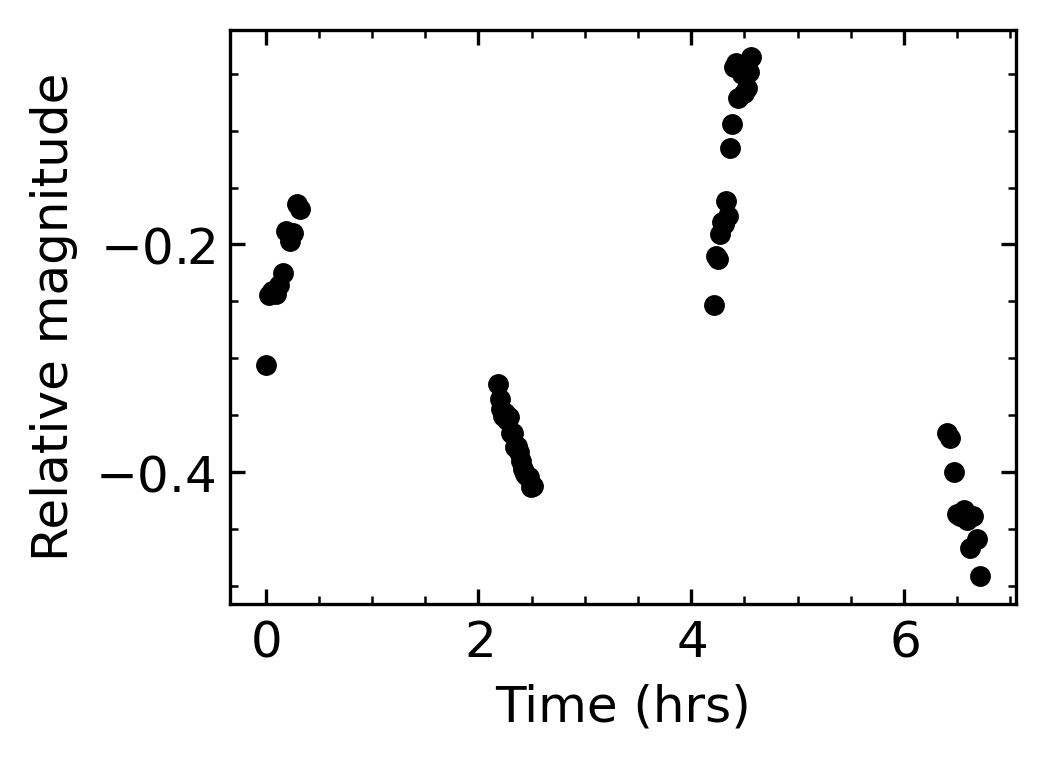

In [3]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

plt.style.use('style.mplstyle') 
plt.figure()
plt.errorbar(data_table['time'], data_table['mag'], yerr=data_table['mag_error'], ls='none', color='k')
plt.scatter(data_table['time'], data_table['mag'], marker='o', color='k')
plt.xlabel('Time (hrs)')
plt.ylabel('Relative magnitude')

plt.show()

{y: a0 + a1*cos(6.28318530717959*x) + a2*cos(12.5663706143592*x) + a3*cos(18.8495559215388*x) + a4*cos(25.1327412287183*x) + a5*cos(31.4159265358979*x) + a6*cos(37.6991118430775*x) + b1*sin(6.28318530717959*x) + b2*sin(12.5663706143592*x) + b3*sin(18.8495559215388*x) + b4*sin(25.1327412287183*x) + b5*sin(31.4159265358979*x) + b6*sin(37.6991118430775*x)}
S 234
468

Parameter Value        Standard Deviation
a0        -2.338374e-01 1.885594e-03
a1        4.126828e-02 2.469253e-03
a2        3.140757e-01 2.775003e-03
a3        2.569892e-02 2.628486e-03
a4        8.284743e-02 2.700378e-03
a5        1.422211e-02 2.580191e-03
a6        4.284529e-02 2.684865e-03
b1        -3.434924e-02 2.853767e-03
b2        -3.155610e-02 2.550189e-03
b3        -3.884087e-03 2.702564e-03
b4        -1.697842e-02 2.660013e-03
b5        -3.133136e-03 2.725186e-03
b6        -1.354564e-02 2.529767e-03
Status message         Optimization terminated successfully.
Number of iterations   21
Objective              <symfi

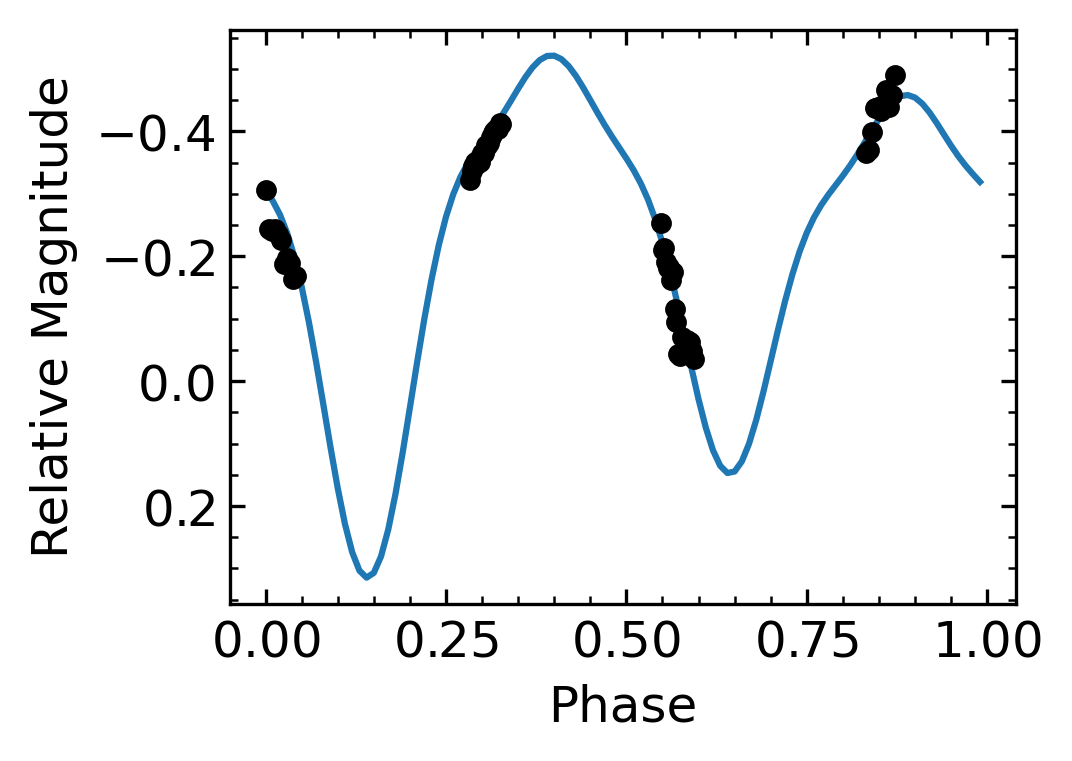

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.modeling.models import custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """
    Returns a symbolic fourier series of order `n`.

    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """
    # Make the parameter objects for all the terms
    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))
    # Construct the series
    series = a0 + sum(ai * cos(2*i * f * x) + bi * sin(2*i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series



x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=np.pi, n=6)}
print(model_dict)


X = np.genfromtxt('archival.txt')

period = 0.3207152 * 24

X, Y = X[:,0], X[:,1]
X = X * period

X +=0.2
X %= period
size = len(X)
print("S",size)
#X = np.concatenate((X,X))
#Y = np.concatenate((Y,Y))
#print("S",len(X))
#X[size:]+=period
#X[size:] += period

double_X = np.concatenate((X,X))
double_Y = np.concatenate((Y,Y))
double_X[size:]+=period

print(len(double_X))
period = 0.3207152 * 24
mean_mag = np.mean(data_table['mag'])
m = mean_mag
m = -2.1374e-01
#a = [0.00874, 0.20441, 0.00606, 0.02943]
#b = [0.00203, -0.00216, -0.00154, 0.00041]
#a = [0.5750, -0.2305, 0.9634, -0.4919]
#b = []
a = [4.126828e-02, 3.140757e-01, 2.569892e-02, 8.284743e-02,1.422211e-02, 4.284529e-02]
#b = [0.00203, -0.00216, -0.00154, 0.00041]
b = [-3.434924e-02,-3.155610e-02,-3.884087e-03, -1.697842e-02,-3.133136e-03,-1.354564e-02]
t = np.arange(0, 1, 0.01)
#t = [0.5]
s = []
x_off = 0.15
for time in t:
    ans = m
    for count, a_n in enumerate(a):
        ans += (a_n*np.cos(2*np.pi*(time-x_off)*(count+1))+b[count]*np.sin(2*np.pi*(time-x_off)*(count+1)))
    s.append(ans)
plt.gca().invert_yaxis()
plt.plot(t,s)
#plt.scatter(double_X/period, double_Y, c="g", alpha=0.1)
#fit = Fit(model_dict, x=X/period, y=Y)
#fit = Fit(model_dict, x=data_table['time']/period, y=data_table['mag'])

fit_result = fit.execute()
print(fit_result)

# Plot the result

#plt.plot(double_X/period, fit.model(x=double_X/period, **fit_result.params).y, color='green', ls=":")
#plt.plot(data_table['time']/period, fit.model(x=data_table['time']/period, **fit_result.params).y, color='green', ls=":")
plt.plot(data_table['time']/period, data_table['mag'], 'o', color='k')
plt.xlabel('Phase')
plt.ylabel('Relative Magnitude')
plt.show()